In [136]:
import geopandas as gpd
import richdem as rd
import rasterio
import rioxarray as rxr
import os
import earthpy as et
import rasterstats as rs
# from rasterstats import zonal_stats
import fiona
import matplotlib.pyplot as plt

### Vector file import (2 methods)

In [71]:
# tracts = fiona.open('data/la_tracts.geojson')

In [81]:
tracts_geodf = gpd.GeoDataFrame.from_file('data/la_tracts.geojson')

In [137]:
tracts_geodf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [142]:
tracts_geodf.total_bounds

array([-118.94464139,   32.79520335, -117.64638732,   34.82330466])

In [143]:
tracts_geodf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

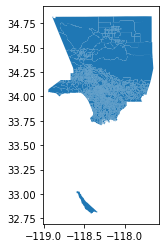

In [82]:
tracts_geodf.plot()

### Land Cover Categorical Raster

In [100]:
land_src = rasterio.open('data/land/NLCD_2019_Land_Cover_L48_20210604_rNuMWD3Z0SuUkIIVRc8K.tiff', driver="GTiff")
land_transform = land_src.meta['transform']

In [38]:
land_transform_manual = (-2158455.0, 30.0, 0.0, 1591005.00, 0.0, -30.0)

In [101]:
land_arr = land_src.read(1)
land_arr

array([[52, 52, 52, ..., 52, 52, 52],
       [52, 52, 52, ..., 52, 52, 71],
       [52, 52, 52, ..., 52, 52, 71],
       ...,
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31]], dtype=uint8)

#### Confirm crs for raster

In [147]:
land_src.bounds

BoundingBox(left=-2158455.0, bottom=1280715.0, right=-1827435.0, top=1591005.0)

### Urban Imperviousness Raster

In [109]:
impv_src = rasterio.open('data/impv/NLCD_2019_Impervious_L48_20210604_rNuMWD3Z0SuUkIIVRc8K.tiff', driver="GTiff")
impv_transform = impv_src.meta['transform']

In [130]:
impv_transform_manual = (-2158455.0, 30.0, 0.0, 1591005.00, 0.0, -30.0)

In [110]:
impv_arr = impv_src.read(1)

### Digital Elevation Raster

In [42]:
dem_src = rasterio.open('data/usgs_merged.tif')
dem_dict = dem_src.profile
dem_dict

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7212, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0002777777777780007, 0.0, -119.001666667182,
       0.0, -0.0002777777777780007, 35.0016666670839), 'tiled': False, 'interleave': 'band'}

In [74]:
dem_aff = dem_dict['transform']
dem_transform_manual = (-119.001666667182, 0.0002777777777780007, 0.0, 35.0016666670839, 0.0, -0.0002777777777780007)

In [75]:
dem_arr = dem_src.read(1)

### Visualizing land raster data

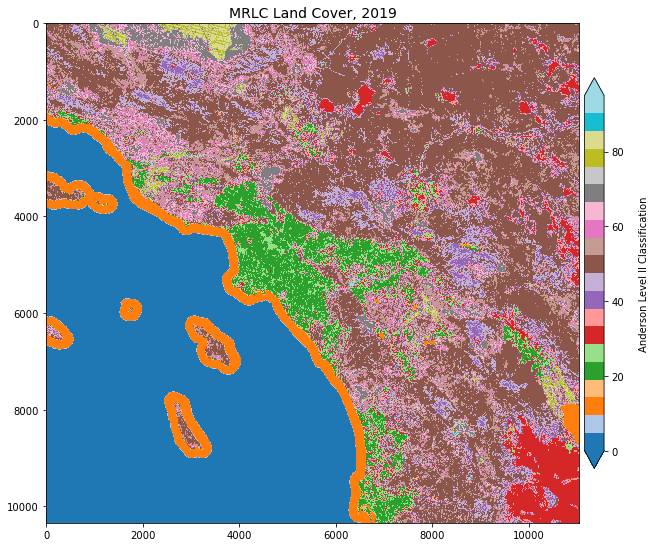

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
landplot = ax.imshow(land_src.read(1), cmap='tab20')
ax.set_title("MRLC Land Cover, 2019", fontsize=14)
cbar = fig.colorbar(landplot, fraction=0.035, pad=0.01, extend='both')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Anderson Level II Classification', rotation=90)
plt.show()

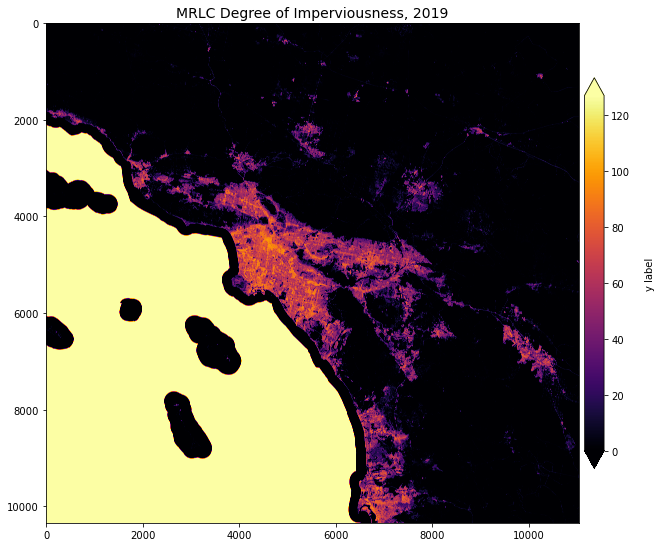

In [128]:
fig, ax = plt.subplots(figsize=(10,10))
impvplot = ax.imshow(impv_src.read(1), cmap='inferno')
ax.set_title("MRLC Degree of Imperviousness, 2019", fontsize=14)
cbar = fig.colorbar(impvplot, fraction=0.035, pad=0.01, extend='both')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('y label', rotation=90)
plt.show()

## Attempt zonal stats for each raster

#### simplest form of rasterstats:

In [131]:
impv_stats = rs.zonal_stats(tracts_geodf, 
                         impv_arr, 
                         stats="majority",
                         copy_properties=True,
                         transform=impv_transform_manual, 
                         nodata=-9999)

In [132]:
impv_stats

[{'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority': None},
 {'majority':

In [76]:
dem_stats = zonal_stats(tracts, dem_arr, transform = dem_transform_manual, nodata=-9999)

In [78]:
len(dem_stats)

2533

In [79]:
dem_stats

[{'min': -0.6592308282852173,
  'max': 598.944580078125,
  'mean': 226.11016536701962,
  'count': 184922},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'min': 1184.0245361328125,
  'max': 1185.452392578125,
  'mean': 1184.7476399739583,
  'count': 3},
 {'min': 258.5460205078125,
  'max': 328.79083251953125,
  'mean': 281.20617608409987,
  'count': 3805},
 {'min': 20.29071617126465,
  'max': 23.055477142333984,
  'mean': 21.50871310763889,
  'count': 1080},
 {'min': 22.660171508789062,
  'max': 32.831417083740234,
  'mean': 24.308732024336283,
  'count': 904},
 {'min': 21.06571388244629,
  'max': 33.38902282714844,
  'mean': 24.44026343437053,
  'count': 1398},
 {'min': 21.471960067749023,
  'max': 24.188756942749023,
  'mean': 22.89697225765306,
  'count': 1225},
 {'min': 5.791260719299316,
  'max': 16.31064224243164,
  'mean': 9.985990887454356,
  'count': 1917},
 {'min': 2.8808374404907227,
  'max': 15.062759399414062,
  'mean': 8.264519202484774,
  'count': 903},
 {'min'